In [2]:
import numpy as np
import torch
import gpytorch

import matplotlib.pyplot as plt

In [4]:
if torch.cuda.is_available():
    print(f"PyTorch CUDA available. Device: {torch.cuda.get_device_name(0)}")
    print(torch.version.cuda)
    print(torch.cuda.device_count())
else:
    print("PyTorch CUDA not available.")


PyTorch CUDA available. Device: NVIDIA GeForce RTX 4060
12.1
1


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [8]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import models
import priors

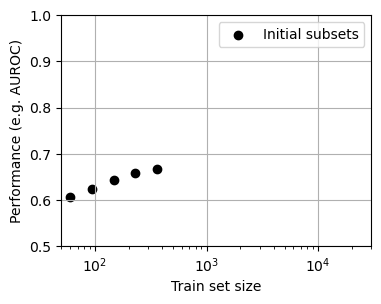

In [10]:
# Define X and Y
X, y = torch.tensor([60, 94, 147, 230, 360], device="cuda:0"), torch.tensor([0.6067, 0.6240, 0.6429, 0.6574, 0.6664], device="cuda:0")
# Plot X and y
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(X.cpu(), y.cpu(), color='black', alpha=1.0, label='Initial subsets')
ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size')
ax.set_ylabel('Performance (e.g. AUROC)')
ax.legend()
ax.grid()
plt.show()

In [12]:
X.device, y.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [15]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Note: If you want to use the Gaussian process with an arctan mean function use models.GPArctan() instead.
model = models.GPPowerLaw(X, y, likelihood, epsilon_min=0.05, with_priors=True)
model = model.to(device)
likelihood = likelihood.to(device)
likelihood, model, losses = models.train_gp(likelihood, model, X, y, max_iters=50000, lr=0.01)

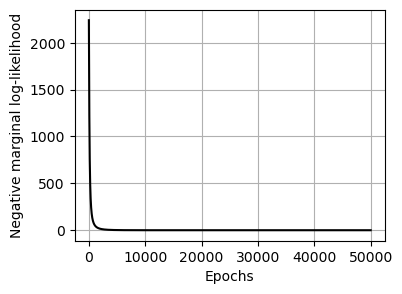

In [31]:
# Check that the model has converged
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.plot(list(range(len(losses))), losses, color='black')
ax.set_xlabel('Epochs')
ax.set_ylabel('Negative marginal log-likelihood')
ax.grid()
plt.show()

In [34]:
# Use predictive posterior to make predictions
linspace = torch.linspace(50, 30000, 29950).long()
with torch.no_grad(): predictions = likelihood(model(linspace))
loc = predictions.mean.numpy()
scale = predictions.stddev.numpy()
# Note: If you want to forecast with 20%-80% change lower and upper percentile.
lower, upper = priors.truncated_normal_uncertainty(0.0, 1.0, loc, scale, lower_percentile=0.025, upper_percentile=0.975) 

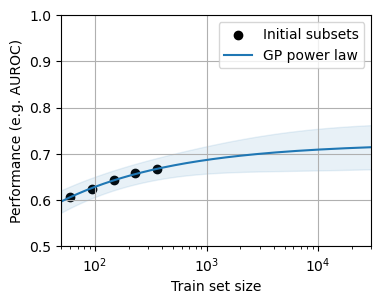

In [40]:
# Plot model
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(X.cpu(), y.cpu(), color='black', alpha=1.0, label='Initial subsets')
ax.plot(linspace.detach().cpu().numpy(), loc, color='#1f77b4', label='GP power law')
ax.fill_between(linspace.detach().cpu().numpy(), lower, upper, color='#1f77b4', alpha=0.1)
ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size')
ax.set_ylabel('Performance (e.g. AUROC)')
ax.legend()
ax.grid()
plt.show()